# Modeling of duration esitmation under memory load

## Model structure

1. Duration Encoding

Given that scalar property is the key feature of duration estimation, the sensory measure (S) is assumed to be a log-scale of physical duration (D):

$$S = \log(D) + \epsilon$$

where $\epsilon$ is the noise term. 

The encoding is influenced by memory load (M) and the encoding function is assumed to be Gausian - $S_{wm} ~ N(\mu_{wm}, \sigma_{wm}^2)$, where $\mu_{wm}$ and $\sigma_{wm}^2$ are the mean and variance of the encoding function.

$$\mu_{wm} = \log{D} - k_sM$$

$$\sigma_{wm}^2 = \sigma_s^2 + l_sM + t_s \log(T)$$

where M represents the set size of the working memory task, T is the retention interval (gap) and $[k_s, l_s, t_s]$ are the scaling factors, $\sigma_s^2$ is the variance of the sensory measure.



## 2. Bayesian integration

Given all trials were randomly intermixed, the posterior probability of the duration estimate is given by $N(\mu_{post}, \sigma_{post}^2)$, where $\mu_{post}$ and $\sigma_{post}^2$ are the mean and variance of the posterior distribution. According to the Bayesian integration theory, the posterior distribution is a weighted sum of the sensory measure and the prior distribution:

$$\mu'_{post} = (1-w_p)\mu_{wm} + w_p\mu_{prior}$$

where
$w_p = \frac{1/\sigma_{prior}^2}{1/\sigma_{wm}^2 + 1/\sigma_{prior}^2}$.


## 3. Duration Reproduction

Having to maintain a number (‘load’) of items in working memory during the duration-reproduction phase would influence the monitoring of the elapsed time of the reproduction. Conceiving of the monitoring of the sensory ‘elapsed time’ (i.e., the time from the starting key press onwards), $\mu_{elapsed}$, as involving the counting of ‘clock ticks’ by an accumulator, lapses and diversion of attention to other, non-temporal processes would result in some ticks being lost, or missed, in the count. Here we assume that the loss is proportional to the memory load, that is: $\mu_{elapsed}-k_rM$, where $k_r$ is a scaling factor. The decision to then release the reproduction key is determined by the comparison between the perceived ‘elapsed time’ and the memorized target duration, $μ'_{post}$:

$$|\mu'_{post}-(\mu_{elapsed}-k_rM)|< \delta $$

which is equivalent to comparing the sensory elapsed time to $\mu'_{post}+k_rM$. 		

We transfer logscal to linear scale:

$$\mu_r = e^{\mu'_{post}+k_rM + {\sigma'}_{post}^2/2}$$

$$\sigma_r^2 = |e^{\sigma_{post}^2} -1|e^{2(\mu_{post}+k_rM)+{\sigma'}_{post}^2}$$

where $\mu_r$ and $\sigma_r^2$ are the mean and variance of the reproduction distribution.

The impact of non-temporal noise will be reduced as duration increases, and we assume:

$$\sigma_{observed}^2 = \sigma_r^2 + \sigma_{non-temporal}^2/D$$

where $\sigma_{non-temporal}^2$ is the variance of the non-temporal noise.

## PYMC Model

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns
import datetime as dt
import os



In [2]:
# print the date of analysis
print('Last updated on:', dt.datetime.now())

Last updated on: 2024-09-15 21:13:27.964387


In [3]:
# get the parent directory
cpath = os.path.dirname(os.getcwd())
# import raw data from csv file cpath + data/AllData.csv
expData = pd.read_csv(cpath + '/data/AllValidData.csv')
# additional experiment 6 : Exp6.csv
exp6 = pd.read_csv(cpath + '/data/Exp6.csv')

# map the column Exp to ExpName: Exp1 -> Baseline, Exp2 -> Encoding, Exp3 -> Reproduction, Exp4 -> Both, Exp5 -> Both_gap
expData['ExpName'] = expData['Exp'].map({'Exp1': 'Baseline', 
										 'Exp2': 'Encoding', 
										 'Exp3': 'Reproduction', 
										 'Exp4': 'Both', 
										 'Exp5': 'Both_gap'})
expData.head()



,WMSize,DurLevel,TPresent,NT,NSub,curDur,repDur,WMRP,valid,stdRepDur,Exp,gap,log_RP,log_dur,Gap,ExpName
0,3,1,1,1,1,0.5,0.742038,2,1,0.203701,Exp1,1,-0.298354,-0.693147,0.5,Baseline
1,3,4,1,2,1,1.4,1.301903,1,1,0.297183,Exp1,1,0.263827,0.336472,0.5,Baseline
2,3,3,1,3,1,1.1,0.805957,1,1,0.201791,Exp1,1,-0.215724,0.095310,0.5,Baseline
3,3,5,2,4,1,1.7,1.253941,2,1,0.168043,Exp1,1,0.226292,0.530628,0.5,Baseline
4,3,4,2,5,1,1.4,0.709891,2,1,0.297183,Exp1,1,-0.342644,0.336472,0.5,Baseline


In [4]:
expData.ExpName.unique()

array(['Baseline', 'Encoding', 'Reproduction', 'Both', 'Both_gap'],
      dtype=object)

In [25]:
# define PYMC partial pooling model
trace = 0
def hModel(dat, constrain):
	# prepare the data
    subid = dat.NSub - 1 # starting from index 0
    nsub = len(dat.NSub.unique())  # number of subject
    wm_idx = np.intc((dat.WMSize.values-1)/2)
    durs = dat.curDur.to_numpy()
    repDur = dat.repDur
    lnRep = dat.log_RP # log-transformed reproduction
    lnDur = np.log(durs)
    T = dat.Gap.to_numpy() # only for the gap manipulation

    niter = 1000
    # define model
    with pm.Model() as WMmodel:
        # sensory measurement
        sig_s = pm.HalfNormal('sig_s',1., shape = nsub) # noise of the sensory measurement
        # auxiliary variables (non-centered parameterization, individual level)
        epsilon = pm.HalfNormal('epsilon', 1, shape = nsub)
        if constrain[0] == 1:
            k_s0 = pm.HalfNormal('k_s',1) # working memory coeff. on ticks
            k_s = epsilon * k_s0
        else:
            k_s = np.zeros(nsub)
        if constrain[1] == 1:
            l_s0 = pm.HalfNormal('l_s',1) # working memory impacts on variance
            l_s = epsilon * l_s0
        else:
            l_s = np.zeros(nsub)
        if constrain[2] == 2:
            t_s0 = pm.HalfNormal('t_s',1)
            t_s = epsilon * t_s0
        else:
            t_s = np.zeros(nsub)
        if constrain[3] == 1:
            k_r0 = pm.HalfNormal('k_r', 1) # working memory influence on reproduction 
            k_r = epsilon * k_r0
        else:
            k_r = np.zeros(nsub) 

        # prior (internal log encoding)
        mu_p = pm.Normal('mu_p', 0, sigma = 1, shape = nsub) # in log space
        sig_p = pm.HalfNormal('sig_p', 1, shape = nsub) # in log-space
        #mu_p = mu_p0 + sig_p[subid] * epsilon

        sig_n0 = pm.HalfNormal('sig_n', 1) #pm.Bound( pm.HalfNormal, lower = 0.15)('sig_n', 5.) # constant decision /motor noise
        sig_n = sig_n0 * epsilon
        # sensory measurement with log encoding + ticks loss by memory task
        D_s = lnDur - k_s[subid] * wm_idx
        sig_sm = sig_s[subid] + l_s[subid] * wm_idx  + t_s[subid] * T # variance influenced by memory tasks
        # integration with prior
        w_p = sig_sm*sig_sm / (sig_p[subid]*sig_p[subid] + sig_sm*sig_sm)
        # posterior
        u_x = (1-w_p)*D_s + w_p * mu_p[subid] # posterior mean
        sig_x2 = sig_sm*sig_sm*sig_p[subid]*sig_p[subid]/(sig_sm*sig_sm + sig_p[subid]*sig_p[subid])
        # reproduction
        # reproduced duration
        u_r = np.exp(u_x + k_r[subid] * wm_idx + sig_x2/2) # reproduced duration with corrupted from memory task
        #reproduced sigmas
        sig_r = np.sqrt((np.exp(sig_x2)-1)*np.exp(2*(u_x + k_r[subid] * wm_idx) +sig_x2 )  + 
            sig_n[subid]*sig_n[subid] /durs)

        # Data likelihood 
        resp_like = pm.Normal('resp_like', mu = u_r, sigma = sig_r, observed = repDur)

        trace = pm.sample(draws=2000, tune = 1000, progressbar=True, return_inferencedata=True)
                  
    #step = pm.Metropolis() # Have a choice of samplers
    #trace = pm.sample(niter, step, start, random_seed=123, progressbar=True)
    return  trace, WMmodel	


# define a function to calculate the mean and sd of posterior samples for each subject
def getPosteriorSummary(posterior_samples, dat):
	# create a dataframe for mean posterior samples with following columns: NSub, curDur, WMSize, mPred, sdPred
	posterior_df = pd.DataFrame(columns = ['NSub', 'curDur', 'WMSize', 'mPred', 'sdPred'])
	# from dat get unique NSub, curDur, WMSize, and loop through them and select rows from dat
	nsub = len(dat.NSub.unique())
	nDur = len(dat.curDur.unique())
	nWM = len(dat.WMSize.unique())
	for i in range(nsub):
		for j in range(nDur):
			for k in range(nWM):
				subid = i
				curDur = dat.curDur.unique()[j]
				WMSize = dat.WMSize.unique()[k]
				idx = (dat.NSub == subid) & (dat.curDur == curDur) & (dat.WMSize == WMSize)
				if np.sum(idx) > 0:
					mPred = np.mean(posterior_samples[:, idx])
					sdPred = np.std(posterior_samples[:, idx])
					df = pd.DataFrame({'NSub': subid, 'curDur': curDur, 'WMSize': WMSize, 'mPred': mPred, 'sdPred': sdPred}, index = [0])
					# concatenate the dataframe
					posterior_df = pd.concat([posterior_df, df], ignore_index = True)
	# calculate the observed means and standard deviations
	mdat = dat.groupby(['NSub', 'curDur', 'WMSize']).agg(
		repDur_mean=('repDur', 'mean'),
		repDur_std=('repDur', 'std')
	).reset_index()

	# Perform the merge with the posterior dataframe on the common keys
	mdat = pd.merge(mdat, posterior_df, on=['NSub', 'curDur', 'WMSize'])

	# Calculate repErr, predErr, repCV, and predCV
	mdat['repErr'] = mdat['repDur_mean'] - mdat['curDur']
	mdat['predErr'] = mdat['mPred'] - mdat['curDur']
	mdat['repCV'] = mdat['repDur_std'] / mdat['repDur_mean']
	mdat['predCV'] = mdat['sdPred'] / mdat['mPred']
	return mdat

# define a function to plot oberved and predicted data (bias, CV, and scatter plot)
def plotModelPred(mdat, figname='model_pred.png'):
	# Ensure WMSize is treated as a categorical variable
	mdat['WMSize'] = mdat['WMSize'].astype('category')
	mmdat = mdat.groupby(['curDur', 'WMSize']).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},
										'repCV': {'mean', 'sem'}, 'predCV': {'mean', 'sem'}}).reset_index()
	mmdat.columns = ['_'.join(filter(None, x)).strip() for x in mmdat.columns.ravel()]	

	# Create a figure and axes with three subplots
	fig, ax = plt.subplots(1, 3, figsize=(12, 4))
	# Set a white background with a more scientific style
	sns.set_theme(style="white", context="paper")
	# Plot the bias (fig_bias) on the left axis (ax[0])
	sns.lineplot(
		data=mmdat, x='curDur', y='predErr_mean', hue='WMSize', 
		ax=ax[0]
	)
	sns.scatterplot(
		data=mmdat, x='curDur', y='repErr_mean', hue='WMSize', 
		ax=ax[0], legend=False
	)
	ax[0].errorbar(
		mmdat['curDur'], mmdat['repErr_mean'], 
		yerr=mmdat['repErr_sem'], fmt='none', capsize=3, color='gray'
	)
	ax[0].set_title('(a) Bias')
	ax[0].set_xlabel('Duration (s)')
	ax[0].set_ylabel('Rep Error Mean (s)')
	ax[0].legend(title='Memory Load')
	# Plot the CV (fig_cv) on the right axis (ax[1])
	sns.lineplot(
		data=mmdat, x='curDur', y='predCV_mean', hue='WMSize', 
		ax=ax[1]
	)
	sns.scatterplot(
		data=mmdat, x='curDur', y='repCV_mean', hue='WMSize', 
		ax=ax[1], legend=False
	)
	ax[1].errorbar(
		mmdat['curDur'], mmdat['repCV_mean'], 
		yerr=mmdat['repCV_sem'], fmt='none', capsize=3, color='gray'
	)
	ax[1].set_title('(b) CV')
	ax[1].set_xlabel('Duration (s)')
	ax[1].set_ylabel('Mean CV')
	ax[1].legend(title='Memory Load')
	# Plot the scatter plot (fig_scatter) on the right axis (ax[2])
	sns.scatterplot(
		data = mdat, x = 'repErr', y = 'predErr', hue = 'WMSize',
		ax = ax[2])
	ax[2].set_title('(c) Observed vs. Predicted Error')
	ax[2].set_xlabel('Observed Error (s)')
	ax[2].set_ylabel('Predicted Error (s)')
	ax[2].legend(title='Memory Load')
	# Adjust the layout
	plt.tight_layout()
	# save the figure
	plt.savefig(cpath + '/analysis/figures/' + figname)
	# Show the plot
	plt.show()





In [26]:
#define runModel function
def runModel(dat, constrain, model_name):
	# run the model
	trace, model = hModel(dat, constrain)
	with model:
		ppc = pm.sample_posterior_predictive(trace, var_names=['resp_like'])
		posterior_resp = ppc.posterior_predictive['resp_like'].to_numpy() # back to linear scale
		posterior_samples = posterior_resp.reshape(-1, posterior_resp.shape[2]) # reshape the array
	# get the mean of posterior samples
	mdat = getPosteriorSummary(posterior_samples, dat)

	# summarize the trace
	para = az.summary(trace)

	# save the trace, model, mdat, and summary
	az.to_netcdf(trace, cpath + '/data/' + model_name + '_trace.nc')
	mdat.to_csv(cpath + '/data/' + model_name + '_mdat.csv')
	para.to_csv(cpath + '/data/' + model_name +'_para.csv')
	return  trace, model, para, mdat

## Experiments with Memory Load on Encoding


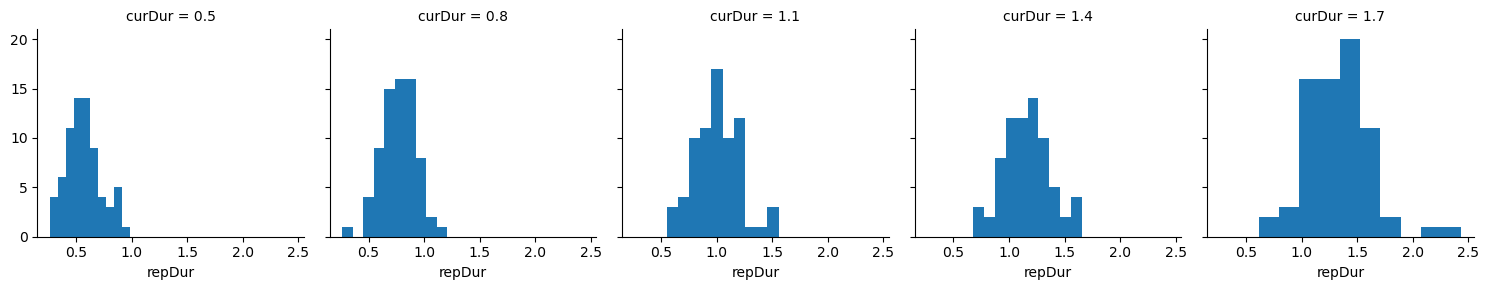

In [9]:
dat_encoding = expData[expData['ExpName'] == 'Encoding']
dat_encoding.NSub.unique()
# using seaborn to show histogram of repDur from one subject , facet by curDur

g = sns.FacetGrid(dat_encoding.query('NSub == 15'), col="curDur", col_wrap=5)
g.map(plt.hist, "repDur")
plt.show()

Using hierarchical Bayesian modeling, we can estimate the parameters of the model. The model is implemented in PYMC. 

In [10]:
firstrun = False
if firstrun:
	constrain = [1,1,0, 0] # scaling factor for k_s, l_s, t_s, k_r
	encoding_trace, encoding_model, encoding_para, encoding_mdat = runModel(dat_encoding, constrain, 'encoding')
	encoding_para
else:
	encoding_trace = az.from_netcdf(cpath + '/data/encoding_trace.nc')
	encoding_mdat = pd.read_csv(cpath + '/data/encoding_mdat.csv')
	encoding_para = pd.read_csv(cpath + '/data/encoding_para.csv')

In [30]:
encoding_para

,Unnamed: 0,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,epsilon[0],1.096,0.258,0.606,1.568,0.005,0.004,2178.0,2637.0,1.0
1,epsilon[1],0.556,0.159,0.273,0.862,0.003,0.002,2411.0,3098.0,1.0
2,epsilon[2],0.638,0.200,0.277,1.028,0.004,0.003,3016.0,3591.0,1.0
3,epsilon[3],0.868,0.228,0.440,1.282,0.004,0.003,2547.0,3591.0,1.0
4,epsilon[4],0.429,0.305,0.000,0.973,0.004,0.003,4603.0,3780.0,1.0
...,...,...,...,...,...,...,...,...,...,...
62,sig_s[11],0.423,0.116,0.217,0.631,0.001,0.001,6838.0,4631.0,1.0
63,sig_s[12],0.347,0.043,0.266,0.427,0.001,0.000,6094.0,3917.0,1.0
64,sig_s[13],0.282,0.022,0.242,0.323,0.000,0.000,6295.0,5532.0,1.0
65,sig_s[14],0.190,0.016,0.160,0.219,0.000,0.000,9350.0,5717.0,1.0


/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_38435/2874369509.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mmdat = mdat.groupby(['curDur', 'WMSize']).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},


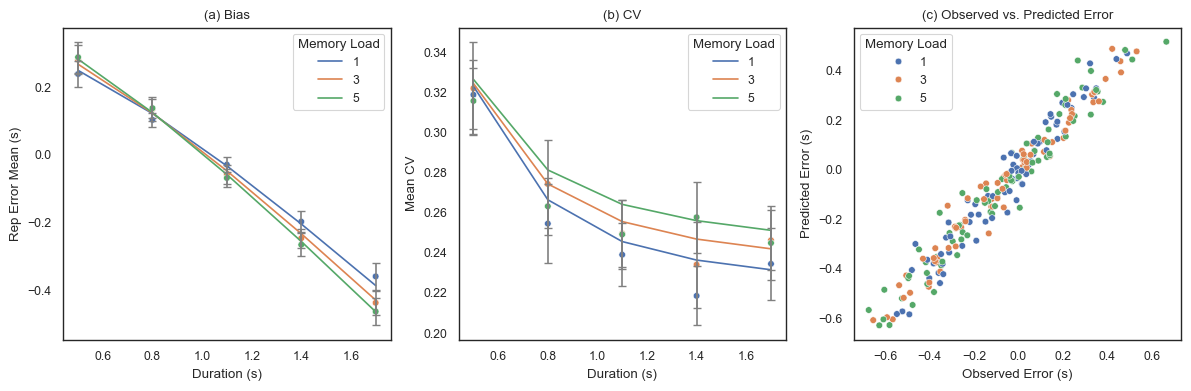

In [27]:
# plot the model prediction
plotModelPred(encoding_mdat, 'encoding')

## Memory Load on Reproduction


In [31]:
dat_reproduction = expData[expData['ExpName'] == 'Reproduction']
firstrun = False
if firstrun:
	constrain = [0,0,0,1] # scaling factor for k_s, l_s, t_s, k_r
	reproduction_trace, reproduction_model, reproduction_para, reproduction_mdat = runModel(dat_reproduction, constrain, 'reproduction')
	reproduction_para
else:
	reproduction_trace = az.from_netcdf(cpath + '/data/reproduction_trace.nc')
	reproduction_mdat = pd.read_csv(cpath + '/data/reproduction_mdat.csv')
	reproduction_para = pd.read_csv(cpath + '/data/reproduction_para.csv')


/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_38435/2874369509.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mmdat = mdat.groupby(['curDur', 'WMSize']).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},


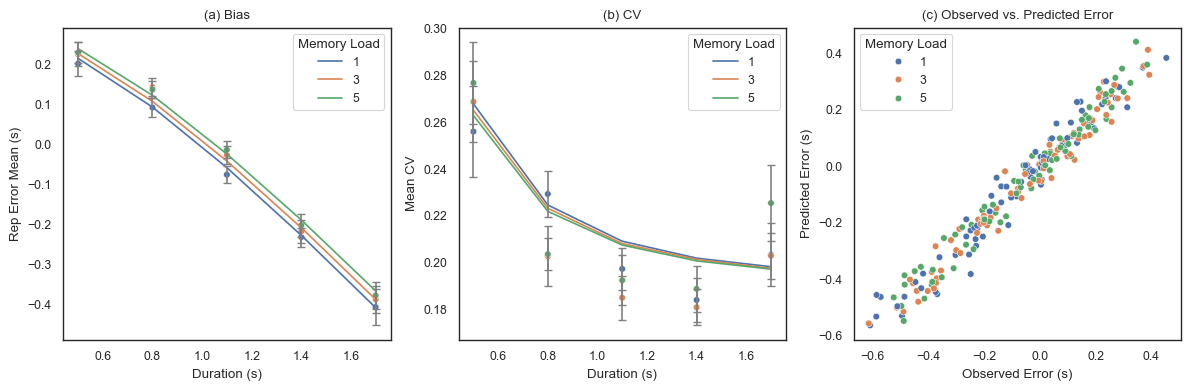

In [32]:
# plot the model prediction
plotModelPred(reproduction_mdat, 'reproduction')

## Memory Load on Encoding and Reproduction


In [34]:
dat_both = expData[expData['ExpName'] == 'Both']
firstrun = False
if firstrun:
	constrain = [1,1,0,1] # scaling factor for k_s, l_s, t_s, k_r
	both_trace, both_model, both_para, both_mdat = runModel(dat_both, constrain, 'both')
	both_para
else:
	both_trace = az.from_netcdf(cpath + '/data/both_trace.nc')
	both_mdat = pd.read_csv(cpath + '/data/both_mdat.csv')
	both_para = pd.read_csv(cpath + '/data/both_para.csv')



/var/folders/dc/hksrz0yj5bb8n7f4_yptkcmw0000gn/T/ipykernel_38435/2874369509.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mmdat = mdat.groupby(['curDur', 'WMSize']).agg({'repErr': {'mean', 'sem'}, 'predErr': {'mean', 'sem'},


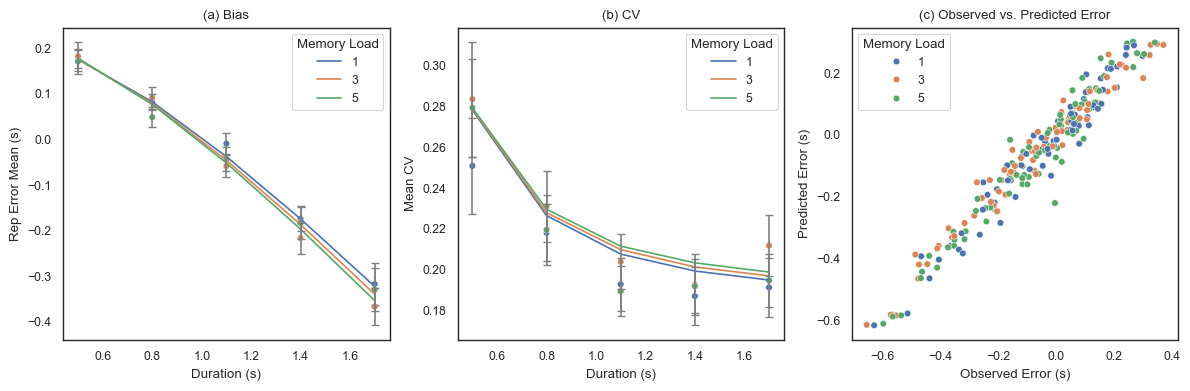

In [35]:
# plot the model prediction
plotModelPred(both_mdat, 'both')

## 